# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Lending Club Project


**Harvard University**<br/>
**Fall 2018**<br/>

<hr style="height:2pt">



In [33]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [34]:
import numpy as np
import pandas as pd
import datetime
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import seaborn as sns
sns.set()
import matplotlib.style
matplotlib.style.use('seaborn-whitegrid')
sns.set_style("white")
from IPython.display import display


<hr style="height:2pt">

<div class='theme'> Overview </div>

### This notebook contains the following sections:
* **Part 1**: Reviews the datasets available from LendingClub
* **Part 2**: Reads in the data  
* **Part 3**: Reviews all of the numerical columns and explains any cleaning or editing
* **Part 4**: Reviews all of the non-numerical columns and explains any cleaning or editing
* **Part 5**: Combines all of the edits in the previous sections into a single function that takes in the raw data and outputs the cleaned dataset


<div class='exercise'><b> Part 1: Datasets available </b></div>


This notebook aims to clean the Lending Club raw data as downloaded from https://www.lendingclub.com/info/download-data.action. 

Two sets of data are available: 
- **Loan data**: data for all loans issued through the time period stated. 
- **Declined loan data**: details of all loan applications that did not meet Lending Club's credit underwriting policy.


The Loan data is split into several datasets covering different time periods. The file names and the years they cover are as follows:

- LoanStats_3a: covers the years 2007 - 2011
- LoanStats_3b: 2012 - 2013
- LoanStats_3c: 2014
- LoanStats_3d: 2015
- After this point, loan data is issued by quarter and the naming format is LoanStats_YYYYQQ, e.g. LoanStats_2016Q1 refers to Q1 of 2016


The Declined loan data have the following file names:

- RejectStatsA: 2007 - 2012
- RejectStatsB: 2013 - 2014
- RejectStatsD: 2015 (nb: there is no "C" file)
- After this point, declined loan data is issued by quarter and follows the naming convention RejectStats_YYYYQQ



For the **loan data**, the datasets contain over 100 predictors. 
- Explanations of these predictors are given in the file LCDataDictionary.xlsx

The **declined loan data** has far fewer predictors. It only contains the following:

- Amount Requested
- Application Date
- Loan Title	
- Risk_Score
- Debt-To-Income Ratio
- Zip Code
- State
- Employment Length
- Policy Code

Therefore I will concentrate on reviewing and cleaning the loan stats dataset, since these have more information. 
<font color = "red">
We may need to return to this and review whether/how to use the declined loan data.

<div class='exercise'><b> Part 2: Read in data and drop uninformative columns </b></div>

### Read in data
I will start by cleaning a dataset from **2017Q1**. 2017 is the latest year for which full data are available. The approach can later be extended to the other datasets. 

Notes:
* Employer Title replaces Employer Name for all loans listed after 9/23/2013) - this will need to be harmonised if we join older datasets
* columns `id` and `member id` have been removed in the raw data.


In [35]:
# There are a lot of columns - increase display
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 150

In [37]:
# Skip the first row when reading in the data to avoid the notes
df = pd.read_csv('data/LoanStats_2017Q1.csv', low_memory = False, 
                  skiprows = 1) 
original_df = df.copy()

In [38]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,13000.0,13000.0,13000.0,36 months,6.99%,401.35,A,A2,Mold Maker,10+ years,MORTGAGE,120000.0,Source Verified,Mar-2017,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,600xx,IL,8.30,0.0,Dec-1997,0.0,42.0,NaN,11.0,0.0,15591.0,52.5%,21.0,f,6839.33,6839.33,7214.20,7214.20,6160.67,1053.53,0.0,0.0,0.0,Oct-2018,401.35,Nov-2018,Oct-2018,0.0,69.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,67371.0,1.0,1.0,0.0,0.0,28.0,2574.0,22.0,1.0,3.0,6942.0,44.0,29700.0,0.0,0.0,0.0,3.0,6737.0,3657.0,73.7,0.0,0.0,168.0,231.0,6.0,6.0,3.0,16.0,42.0,13.0,42.0,2.0,3.0,7.0,3.0,4.0,3.0,9.0,15.0,7.0,11.0,0.0,0.0,0.0,1.0,76.2,33.3,0.0,0.0,239301.0,18165.0,13900.0,12000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,9000.0,9000.0,9000.0,36 months,10.49%,292.48,B,B2,Director of Sales,3 years,RENT,172000.0,Not Verified,Mar-2017,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,101xx,NY,21.71,0.0,Sep-1994,1.0,73.0,NaN,15.0,0.0,16560.0,64.2%,30.0,w,4851.77,4851.77,5254.15,5254.15,4148.23,1105.92,0.0,0.0,0.0,Oct-2018,292.48,Nov-2018,Oct-2018,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,94190.0,1.0,4.0,0.0,3.0,18.0,37956.0,59.0,1.0,1.0,5940.0,61.0,25800.0,0.0,0.0,1.0,4.0,6728.0,5109.0,73.3,0.0,0.0,270.0,173.0,4.0,4.0,0.0,76.0,NaN,4.0,NaN,0.0,4.0,7.0,5.0,6.0,16.0,10.0,13.0,7.0,15.0,0.0,0.0,0.0,1.0,96.7,80.0,0.0,0.0,129752.0,94190.0,19100.0,64278.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,12000.0,12000.0,12000.0,36 months,7.99%,375.99,A,A5,registerd nurse,9 years,MORTGAGE,100000.0,Verified,Mar-2017,La

In [39]:
df.shape

(96781, 145)

In [40]:
# Check the number of missing data points in each column
df.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96781 entries, 0 to 96780
Data columns (total 145 columns):
id                                            2 non-null object
member_id                                     0 non-null float64
loan_amnt                                     96779 non-null float64
funded_amnt                                   96779 non-null float64
funded_amnt_inv                               96779 non-null float64
term                                          96779 non-null object
int_rate                                      96779 non-null object
installment                                   96779 non-null float64
grade                                         96779 non-null object
sub_grade                                     96779 non-null object
emp_title                                     89887 non-null object
emp_length                                    89987 non-null object
home_ownership                                96779 non-null object
annual_in

### Drop erroneous rows

We can see from the shape of the data as compared to the number of non-null objects in each column that the data read-in has picked up two empty rows that are NaN for all variables. These are removed. 

In [41]:
cols_drop_nan = ["loan_amnt"]
rows_to_drop = df[df["loan_amnt"].isnull()].index.tolist()
rows_to_drop

[96779, 96780]

In [9]:
df.drop(rows_to_drop, inplace = True)

In [10]:
df.shape

(96779, 145)

### Dropping uninformative columns

We can immediately see quite a few columns with 0 non-null values, which can be dropped because the columns are unlikely to contain information useful to us. These are:
* `id`: Loan identifier numbers. Removed from the raw dataset
* `member_id`: Unique member id. Removed from the raw dataset
* `url`: URL for the LC page with listing data.
* `desc`: Loan description provided by the borrower

The debt_settlement-related variables (`debt_settlement_flag_date`, `settlement_status`, `settlement_amount`, `settlement_percentage`, `settlement_term`) refer to the details of whether the borrower is working with a debt settlement company. These represent more detailed data associated with the `debt_settlement_flag`, but since this is already a rare occurrence, the additional detail does not seem necessary. I have dropped these columns.

Similarly the `hardship flag` also has a number of related variables (`hardship_type`, `hardship_reason` etc). This is a plan offered by Lendingclub that allows borrowers to make interest-only payments for up to 3 months, to accommodate an unexpected life event. I have dropped all of these columns since the additional detail does not seem necessary. 

<font color = red>
Notes: 
* The hardship plans were only introduced in 2017 - if we decide to use older data we may need to consider this.


In [11]:
# Candidate columns for removal
empty_cols = ["id", "member_id", "url", "desc"] # Obvious ones
debt_settlement_cols = ["debt_settlement_flag_date", "settlement_status", "settlement_amount", "settlement_percentage", "settlement_term", "settlement_date"]
hardship_flag_cols =["hardship_type", "hardship_reason", "hardship_status", "deferral_term", "hardship_amount", "hardship_start_date", "hardship_end_date", "payment_plan_start_date", "hardship_length", "hardship_dpd", "hardship_loan_status", "orig_projected_additional_accrued_interest", "hardship_payoff_balance_amount", "hardship_last_payment_amount"]


In [12]:
# List of columns to drop
cols_to_drop = empty_cols + debt_settlement_cols + hardship_flag_cols

In [13]:
# Remove columns mentioned
df.drop(columns = cols_to_drop, inplace = True)

<div class='exercise'><b> Part 3: Review numerical columns </b></div>

### Review data description

In this part, I will review the numerical data and perform any necessary cleaning.  I have concentrated on reviewing columns with a lot of missing values. 

* There are probably quite a few columns that can be dropped due to colinearity or data leakage, but since we have not fully foumulated a research question yet, it seems sensible to leave these in and review this as part of the EDA. 
* Data scaling will be performed later on when splitting into training and test sets.

In [14]:
desc = df.describe().T
display(desc)

,count,mean,std,min,25%,50%,75%,max
loan_amnt,96779.0,14858.279947,9396.273231,1.000000e+03,7800.000000,12000.00,20000.000000,4.000000e+04
funded_amnt,96779.0,14858.279947,9396.273231,1.000000e+03,7800.000000,12000.00,20000.000000,4.000000e+04
funded_amnt_inv,96779.0,14853.928022,9393.128515,1.000000e+03,7800.000000,12000.00,20000.000000,4.000000e+04
installment,96779.0,450.860481,283.490182,3.012000e+01,244.300000,372.71,602.300000,1.715420e+03
annual_inc,96779.0,82761.037094,214944.195321,0.000000e+00,49000.000000,70000.00,99500.000000,6.100000e+07
dti,96746.0,18.649828,12.697500,-1.000000e+00,12.240000,17.98,24.340000,9.990000e+02
delinq_2yrs,96779.0,0.349642,0.929675,0.000000e+00,0.000000,0.00,0.000000,2.100000e+01
inq_last_6mths,96779.0,0.505192,0.803738,0.000000e+00,0.000000,0.00,1.000000,5.000000e+00
mths_since_last_delinq,50486.0,33.552787,21.877887,0.000000e+00,15.000000,30.00,49.000000,1.370000e+02
mths_since_last_record,19105.0,68.747396,25.560842,0.000000e+00,53.000000,72.00,87.000000,1.200000e+02


### `policy_code`
Takes only a single value (1) and therefore is uninformative.
* This column will be dropped

In [15]:
# Add policy_code to the list of cols to drop
cols_to_drop = cols_to_drop + ["policy_code"]

### Review columns with the most missing values

In [16]:
# Sort columns by number of null values
desc = df.describe().T
desc = desc.iloc[:, 0:1]
desc["nulls"] = 96779 - desc["count"]
null_vals = desc[desc["nulls"] > 0]
null_vals.sort_values(by = ["nulls"], ascending = False)

,count,nulls
sec_app_mths_since_last_major_derog,356.0,96423.0
sec_app_revol_util,1019.0,95760.0
sec_app_chargeoff_within_12_mths,1025.0,95754.0
sec_app_mort_acc,1025.0,95754.0
sec_app_open_acc,1025.0,95754.0
sec_app_open_act_il,1025.0,95754.0
revol_bal_joint,1025.0,95754.0
sec_app_num_rev_accts,1025.0,95754.0
sec_app_collections_12_mths_ex_med,1025.0,95754.0
sec_app_inq_last_6mths,1025.0,95754.0


### `Sec_...`
The columns with the most missing values relate to details of a second applicant in a joint application (all columns starting with `sec_` or ending in `_joint`). Since these are only filled in for joint applications, it makes sense that there would be a lot of missing values.

* I have created a list of these columns so that they can either be dropped or cleaned together
* For now I have replaced missing values with 0
* The exception is `sec_app_mths_since_last_major_derog`, which refers to the months since most recent 90-day or worse rating at time of application for the secondary applicant. Filling missing values with 0 would suggest that there had been a recent occurrence, when in fact the missing values mean that there has never been an occurrence.  This column is turned into a binary column with 0 meaning no occurrence and 1 meaning there has been an occurrence. 
<font color = "red">
* We may want to drop these later - they might not be informative


In [17]:
# List of all numerical columns related to joint applications
joint_app_cols = ["sec_app_revol_util", "sec_app_collections_12_mths_ex_med", "sec_app_chargeoff_within_12_mths", "sec_app_num_rev_accts", "sec_app_open_act_il", "sec_app_open_acc", "sec_app_mort_acc", "sec_app_inq_last_6mths", "revol_bal_joint", "annual_inc_joint", "dti_joint"]


In [18]:
# Edit: Replace NaNs with 0
for i in joint_app_cols:
    df[i] = df[i].replace(np.nan, 0)

In [19]:
# Edit: simplify sec_app_mths_since_last_major_derog to binary. 0 = no occurrence, 1 = occurrence
df["sec_app_mths_since_last_major_derog2"] = df["sec_app_mths_since_last_major_derog"].apply(lambda x: 1 if not pd.isnull(x) else 0)

In [20]:
# Drop original column and check output
df.drop(columns = ["sec_app_mths_since_last_major_derog"], inplace = True)
df["sec_app_mths_since_last_major_derog2"].value_counts(dropna = False).to_frame()

,sec_app_mths_since_last_major_derog2
0,96423
1,356


In [21]:
# Recheck columns by number of null values
desc = df.describe().T
desc = desc.iloc[:, 0:1]
desc["nulls"] = 96779 - desc["count"]
null_vals = desc[desc["nulls"] > 0]
null_vals.sort_values(by = ["nulls"], ascending = False)

,count,nulls
mths_since_last_record,19105.0,77674.0
mths_since_recent_bc_dlq,23792.0,72987.0
mths_since_last_major_derog,27091.0,69688.0
mths_since_recent_revol_delinq,34459.0,62320.0
mths_since_last_delinq,50486.0,46293.0
il_util,83781.0,12998.0
mths_since_recent_inq,85465.0,11314.0
num_tl_120dpd_2m,92073.0,4706.0
mths_since_rcnt_il,94183.0,2596.0
mo_sin_old_il_acct,94183.0,2596.0


### `mths_since...`
All of the **`mths_since...`** variables have many missing values.  As for  `sec_app_mths_since_last_major_derog`, we cannot replace NaNs with 0's since this would suggest that there had been a recent occurrence.  
* These columns are all turned into binary columns with 0 meaning no occurrence and 1 meaning there has been an occurrence. 

In [22]:
mths_since_cols = ["mths_since_last_record", "mths_since_recent_bc_dlq", "mths_since_last_major_derog", "mths_since_recent_revol_delinq", "mths_since_last_delinq", "mths_since_recent_inq", 
"mo_sin_old_il_acct", "mths_since_rcnt_il", "mths_since_recent_bc"]

# Edit: change each columns to binary. 0 = no occurrence, 1 = occurrence
for i in mths_since_cols:
    df[i] = df[i].apply(lambda x: 1 if not pd.isnull(x) else 0)

In [23]:
# Recheck columns by number of null values
desc = df.describe().T
desc = desc.iloc[:, 0:1]
desc["nulls"] = 96779 - desc["count"]
null_vals = desc[desc["nulls"] > 0]
null_vals.sort_values(by = ["nulls"], ascending = False)

,count,nulls
il_util,83781.0,12998.0
num_tl_120dpd_2m,92073.0,4706.0
bc_util,95751.0,1028.0
percent_bc_gt_75,95792.0,987.0
bc_open_to_buy,95794.0,985.0
dti,96746.0,33.0
all_util,96776.0,3.0


### `il_util` to `bc_open_to_buy`

The following columns do not seem that informative, so rather than trying to fill in missing values, they are all dropped. 
* `il_util` Refers to the "ratio of total current balance to high credit/credit limit on all install acct". Since it refers to the current status of the loan, we can drop this.
* `bc_util` Ratio of total current balance to high credit/credit limit for all bankcard accounts.
* `num_tl_120dpd_2m` Number of accounts currently 120 days past due (updated in past 2 months). Since it overlaps with the other `num_tl_...` columns, it can be dropped
* `percent_bc_gt_75	` Percentage of all bankcard accounts > 75% of limit.
* `bc_open_to_buy` Total open to buy on revolving bankcards. Again, refers to current status of loan

In [24]:
# Add to the list of cols to drop
cols_to_drop = cols_to_drop + ["il_util", "num_tl_120dpd_2m", "bc_util", "percent_bc_gt_75", "bc_open_to_buy"]

### `dti` 
This is the debt-to-income ratio, which seems like an important variable. More specifically it is a ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

Taking a closer look at this, we can see that the income for the NaN values is zero (apart from two values where annual income is 1, i.e. practically zero).  We can also see that in these cases, there is a joint_dti.

* In this case, I have filled the missing values with the joint_dti values
<font color = "red"> 
* Check this makes sense!

In [25]:
dti_nulls = df.loc[df["dti"].isnull()]
dti_nulls.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,disbursement_method,debt_settlement_flag,sec_app_mths_since_last_major_derog2
567,12000.0,12000.0,12000.0,36 months,7.99%,375.99,A,A5,NaN,NaN,RENT,0.0,Not Verified,Mar-2017,Current,n,debt_consolidation,Debt consolidation,921xx,CA,NaN,0.0,Aug-2007,0.0,0,0,4.0,0.0,11081.0,51.3%,12.0,w,6357.76,6357.76,6733.200000,6733.20,5642.24,1090.96,0.0,0.0,0.0,Sep-2018,375.99,Oct-2018,Dec-2017,0.0,0,1.0,Joint App,98000.0,11.63,Not Verified,0.0,0.0,11081.0,0.0,0.0,0.0,0.0,1,0.0,NaN,0.0,1.0,8874.0,51.0,21600.0,0.0,0.0,0.0,1.0,2770.0,10419.0,51.5,0.0,0.0,1,115.0,17.0,17.0,0.0,1,0,0,0,0.0,3.0,3.0,3.0,6.0,1.0,4.0,11.0,3.0,4.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,21600.0,11081.0,21500.0,0.0,20789.0,Dec-2004,0.0,0.0,6.0,40.8,1.0,12.0,0.0,0.0,N,Cash,N,1
1014,10000.0,10000.0,10000.0,60 months,10.49%,214.89,B,B2,NaN,NaN,MORTGAGE,0.0,Not Verified,Mar-2017,Current,n,credit_card,Credit card refinancing,169xx,PA,NaN,0.0,May-2005,0.0,1,0,9.0,0.0,4557.0,48%,10.0,w,7674.57,7674.57,3641.470000,3641.47,2325.43,1316.04,0.0,0.0,0.0,Sep-2018,214.89,Oct-2018,Sep-2018,0.0,0,1.0,Joint App,72000.0,11.87,Not Verified,0.0,0.0,87370.0,0.0,3.0,0.0,0.0,1,18777.0,66.0,1.0,2.0,4557.0,61.0,9500.0,0.0,0.0,0.0,2.0,10921.0,243.0,94.9,0.0,0.0,1,43.0,9.0,9.0,1.0,1,0,1,0,0.0,1.0,1.0,1.0,1.0,4.0,5.0,5.0,1.0,9.0,0.0,0.0,0.0,1.0,90.0,100.0,0.0,0.0,107273.0,23334.0,4800.0,28473.0,10107.0,Jan-2002,0.0,3.0,8.0,56.5,1.0,8.0,0.0,0.0,N,Cash,N,1
1630,25000.0,25000.0,25000.0,36 months,11.49%,824.29,B,B5,NaN,NaN,RENT,0.0,Not Verified,Mar-2017,Current,n,debt_consolidation,Debt consolidation,483xx,MI,NaN,0.0,Dec-2006,1.0,0,1,8.0,1.0,1815.0,14.5%,9.0,w,14257.05,14257.05,13981.010000,13981.01,10742.95,3238.06,0.0,0.0,0.0,Sep-2018,824.29,Oct-2018,Mar-2017,0.0,0,1.0,Joint App,100000.0,7.22,Not Verified,0.0,0.0,20446.0,0.0,1.0,1.0,1.0,1,18631.0,93.0,0.0,0.0,1532.0,63.0,12500.0,0.0,1.0,2.0,1.0,2556.0,10085.0,15.3,0.0,0.0,1,123.0,38.0,7.0,0.0,1,0,1,0,0.0,2.0,2.0,6.0,7.0,1.0,7.0,8.0,2.0,8.0,0.0,0.0,0.0,1.0,100.0,0.0,1.0,0.0,32500.0,20446.0,11900.0,20000.0,8376.0,Dec-1994,2.0,0.0,12.0,60.0,6.0,9.0,0.0,0.0,N,Cash,N,0
1743,5400.0,5400.0,5400.0,36 months,12.74%,181.28,C,C1,NaN,NaN,MORTGAGE,0.0,Not Verified,Mar-2017,Fully Paid,n,debt_consolidation

In [26]:
dti_nulls["annual_inc"].value_counts(dropna = False).to_frame()

,annual_inc
0.0,31
1.0,2


In [27]:
# Edit: gap fill dti using joint_dti values 
df["dti"].fillna(df["dti_joint"], inplace = True)

In [28]:
df["dti"].isnull().sum()

0

### `all_util`

Refers to the balance to credit limit on all trades. 
* There are only 3 missing values, which I have dropped


In [29]:
df["all_util"].isnull().sum()

3

In [30]:
# Edit: add to list of columns from which to drop NaNs
cols_drop_nan = cols_drop_nan + ["all_util"]

That is all of the numerical columns. Things to do in the next stage will be to check colinearity and data leakage.

<div class='exercise'><b> Part 4: Review non-numerical columns </b></div>
### Review non-numerical columns
In this part, I will review each non-numerical column and perform any necessary cleaning.

In [31]:
# List the object columns
objects = list(df.select_dtypes(include = "object"))
objects

['term',
 'int_rate',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'revol_util',
 'initial_list_status',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'verification_status_joint',
 'sec_app_earliest_cr_line',
 'hardship_flag',
 'disbursement_method',
 'debt_settlement_flag']

### Dates

* Firstly, there are a several dates that are currently object types. 
* I have kept the following variables and converted to dates: 
    * `issue_d` the month the loan was funded
    * `earliest_cr_line` the month the borrower's earliest reported credit line was opened
    * `sec_app_earliest_cr_line`  earliest credit line at time of application for the secondary applicant
* Others are not relevant to us, since they relate to payments at the time that the data was generated:
    * `last_pymt_d` last month payment was received
    * `next pymt_d` next scheduled payment date
    * `last_credit_pull_d` the most recent month LC pulled credit for this loan

In [32]:
# Select all the date columns and decide whether to transform to dates or drop
date_cols_to_keep = ["issue_d", "earliest_cr_line"]
date_cols_to_drop = ["last_pymnt_d", "next_pymnt_d", "last_credit_pull_d", "sec_app_earliest_cr_line"]

In [33]:
# Change to dates
for i in date_cols_to_keep:
    df[i] = pd.to_datetime(df[i])

Now I will go through the remaining object columns.

### `Term`
Refers to the number of payments on the loan. 

* Values are in months and can be either 36 or 60.
* This seems worth simplifying to a binary variable

In [34]:
df["term"].value_counts(dropna = False).to_frame()

,term
36 months,72410
60 months,24369


In [35]:
# Edit: simplify term to a binary variable: 36 months = 0, 60 months = 1
df["term"].replace({" 36 months": 0, " 60 months": 1}, inplace = True)

### `int_rate`
The interest rate. 
* It seems that the % sign in the column means that it has been interpreted as an object. 
* It would make more sense to be a numerical value. 

In [36]:
df["int_rate"].value_counts(dropna = False).to_frame().head()

,int_rate
12.74%,8716
11.49%,7899
14.99%,6452
13.49%,6300
15.99%,6256


In [37]:
# Edit: Strip out % signs and change int_rate to float
df["int_rate"] = [x.strip("%") for x in df["int_rate"].astype(str)]
df["int_rate"] = df["int_rate"].astype(float)

In [38]:
df["int_rate"].isna().sum()

0

### `grade` and `sub_grade`

There are the grades assigned by LC. 

* These seem absolutely fine
* There are no missing values for either column once the two NaNs from above have been removed

<font color = "red">
* May want to encode these as ordered numbers later on, i.e. 1-6 instead of letter grades

In [39]:
df["grade"].value_counts(dropna = False).to_frame()

,grade
C,33699
B,28776
A,14976
D,12029
E,5056
F,1735
G,508


In [40]:
df["grade"].isna().sum()

0

In [41]:
df["sub_grade"].value_counts(dropna = False).to_frame()

,sub_grade
C1,8718
B5,7902
C4,6455
C2,6305
C5,6257
B1,6184
C3,5964
B4,5499
B3,4715
B2,4476


In [42]:
sub_grade_list = df.sub_grade.astype(str).unique()
sub_grade_list.sort()
sub_grade_list

array(['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2',
       'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3',
       'G4', 'G5'], dtype=object)

### `emp_title`
Refers to the job title supplied by the Borrower when applying for the loan. 
* We can see that there are around 35,500 categories (most of which only have a few values)
* This would need significant cleaning, as we can see there are multiple job titles that refer to the same role (RN vs Registered Nurse and Owner/owner). 
* There doesn't seem to be much value in keeping this column, so it can be dropped.

In [43]:
df["emp_title"].value_counts(dropna = False).to_frame().head(n = 10)

,emp_title
NaN,6892
Teacher,1813
Manager,1620
Owner,1398
Driver,756
Registered Nurse,728
RN,724
Sales,682
Supervisor,595
Project Manager,542


In [44]:
len(df["emp_title"].unique())

35501

In [45]:
# Add emp_title to the list of cols to drop
cols_to_drop = cols_to_drop + ["emp_title"]

### `emp_length`
The employment length in years. 
* Possible values are between 0 and 10+ years
* It seems worth changing this to a numerical value
* There are a lot of NaNs here: I assume that this is because the applicant has never been employed, and therefore these are coded as 0's
* All other values are coded as number of years

In [46]:
df["emp_length"].value_counts(dropna = False).to_frame()

,emp_length
10+ years,33365
2 years,9052
3 years,8180
< 1 year,6951
NaN,6792
1 year,6421
5 years,6042
4 years,5727
6 years,4248
9 years,3580


In [47]:
# Edit: Change emp_length to numeric
emp_dict = {"< 1 year":0.5, # Choose 0.5 instead of 0 to distinguish from NaN
            "1 year":1,
            "2 years":2,
            "3 years":3,
            "4 years":4,
            "5 years":5,
            "6 years":6,
            "7 years":7,
            "8 years":8,
            "9 years":9,
            "10+ years":10,
            "n/a":0}
df["emp_length"].replace(emp_dict, inplace = True)
df["emp_length"] = df["emp_length"].replace(np.nan, 0)

In [48]:
df["emp_length"].unique()

array([10. ,  4. ,  1. ,  3. ,  0. ,  8. ,  6. ,  9. ,  0.5,  5. ,  2. ,
        7. ])

### `Home ownership`
The home ownership status provided by the borrower during registration. 
* This seems OK but later we might want to combine the categories ANY and NONE. 
* No missing values
* For now I have left it unedited

In [49]:
df["home_ownership"].value_counts(dropna = False).to_frame()

,home_ownership
MORTGAGE,48083
RENT,37179
OWN,11135
ANY,381
NONE,1


### `verification_status` and  `verification_status_joint`
Indicates if income was verified by LC, not verified, or if the income source was verified.
*  `verification_status` seems fine - no action
*  `verification_status_joint` has a lot of missing values, presumably referring to individual applications. This seems overly detailed, so it is dropped.


In [50]:
df["verification_status"].value_counts(dropna = False).to_frame()

,verification_status
Source Verified,39703
Not Verified,29531
Verified,27545


In [51]:
df["verification_status_joint"].value_counts(dropna = False).to_frame()

,verification_status_joint
NaN,92372
Not Verified,3754
Verified,337
Source Verified,316


In [52]:
pd.crosstab(df["verification_status"], df["verification_status_joint"])

verification_status_joint,Not Verified,Source Verified,Verified
verification_status,,,
Not Verified,1091,0,0
Source Verified,931,251,0
Verified,1732,65,337


In [53]:
# Add verficiation_status_joint to the list of cols to drop
cols_to_drop = cols_to_drop + ["verification_status_joint"]

### `loan_status`
Gives the current status of the loan. 
* This seems fine for now - no action 
* Note: later on we might want to combine loan categories

In [54]:
df["loan_status"].value_counts(dropna = False).to_frame()

,loan_status
Current,58483
Fully Paid,27526
Charged Off,7493
Late (31-120 days),1906
In Grace Period,998
Late (16-30 days),370
Default,3


### `pyment_plan`
Indicates if a payment plan has been put in place for the loan.
* There are such a small number of y values that it doesn't seem worth keeping.
* It also overlaps heavily with the hardship flag
* For now, I have removed it
<font color = red>

* To check whether we want to keep payment_plan and drop hardship_flag instead - or possibly drop both

In [55]:
df["pymnt_plan"].value_counts(dropna = False).to_frame()

,pymnt_plan
n,96697
y,82


In [56]:
# Seems to overlap heavily with the harship flag
pd.crosstab(df.hardship_flag, df.pymnt_plan)

pymnt_plan,n,y
hardship_flag,,
N,96669,0
Y,28,82


In [57]:
# Add payment_plan to the list of cols to drop
cols_to_drop = cols_to_drop + ["pymnt_plan"]

### `hardship_flag`** and **`debt_settlement_flag`

* Both are recoded as binary variables

In [58]:
df["hardship_flag"].value_counts(dropna = False).to_frame()

,hardship_flag
N,96669
Y,110


In [59]:
df["debt_settlement_flag"].value_counts(dropna = False).to_frame()

,debt_settlement_flag
N,96067
Y,712


In [60]:
# Edit: Recode flags as N = 0, Y = 1
df["hardship_flag"].replace({"N": 0, "Y": 1}, inplace = True)
df["debt_settlement_flag"].replace({"N": 0, "Y": 1}, inplace = True)

### `title` and `purpose`
Both describe a reason for the loan. 

* The dataset descriptions provided state that `title` is the loan title provided by the borrower and `purpose` is a category provided by the borrower for the loan request. 
* Cross tabulation shows there is very high correspondence between the two.
* Since there doesn't seem to be much value in keeping both, we will keep `title` and drop `purpose`. 

In [61]:
df["purpose"].value_counts(dropna = False).to_frame()

,purpose
debt_consolidation,54811
credit_card,21009
home_improvement,7059
other,6131
major_purchase,2172
medical,1353
small_business,1145
car,1118
vacation,780
moving,704


In [62]:
df["title"].value_counts(dropna = False).to_frame()

,title
Debt consolidation,54807
Credit card refinancing,21017
Home improvement,7058
Other,6130
Major purchase,2167
Medical expenses,1353
Business,1146
Car financing,1121
Vacation,780
Moving and relocation,704


In [63]:
pd.crosstab(df["title"], df["purpose"])

purpose,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation
title,,,,,,,,,,,,
Business,0,0,1,0,0,0,0,0,0,0,1145,0
Car financing,1118,0,1,0,0,2,0,0,0,0,0,0
Credit card refinancing,0,21004,12,1,0,0,0,0,0,0,0,0
Debt consolidation,0,5,54795,2,0,3,0,0,2,0,0,0
Green loan,0,0,0,0,0,0,0,0,0,67,0,0
Home buying,0,0,0,0,429,0,0,0,0,0,0,0
Home improvement,0,0,2,7056,0,0,0,0,0,0,0,0
Major purchase,0,0,0,0,0,2167,0,0,0,0,0,0
Medical expenses,0,0,0,0,0,0,1353,0,0,0,0,0


In [64]:
# Add purpose to the list of cols to drop
cols_to_drop = cols_to_drop + ["purpose"]

### `zip code` and `addr_state`
Both show the location of the borrower. 
* It does not seem necessary to have both so I will keep `addr_state` since that has a more managable number of categories.
* No further cleaning needed

In [65]:
df["zip_code"].value_counts().to_frame().head()

,zip_code
112xx,1043
750xx,1037
945xx,1004
606xx,890
300xx,851


In [66]:
df["addr_state"].value_counts(dropna = False).to_frame().head()

,addr_state
CA,13365
TX,8331
NY,8038
FL,6652
IL,3809


In [67]:
df["addr_state"].isna().sum()

0

In [68]:
# Add zip to the list of cols to drop
cols_to_drop = cols_to_drop + ["zip_code"]

### `revol_util`
The revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit. 

* This should be transformed in the same way as for int_rate

<font color = "red">
* There are 51 missing values - I have filled these with the values from `sec_app_revol_util`

In [69]:
df["revol_util"].value_counts().to_frame().head()

,revol_util
0%,372
39%,222
42%,211
52%,210
56%,210


In [70]:
df["revol_util"].isna().sum()

51

In [71]:
# Edit to remove % from revol_util and change to numerical
df["revol_util"] = [x.strip("%") for x in df["revol_util"].astype(str)]
df["revol_util"] = df["revol_util"].astype(float)

# Fill missing values with value from sec_app_revol_util  
df["revol_util"].fillna(df["sec_app_revol_util"], inplace = True)

In [72]:
df["revol_util"].isna().sum()

0

### `initial_list_status`
Only takes two values: 
* w for whole 
* f for fractional
* Recode as binary: whole = 1, fractional = 0

In [73]:
df["initial_list_status"].value_counts(dropna = False).to_frame()

,initial_list_status
w,68872
f,27907


In [74]:
# Edit: Recode initial_list_status as w = 1, f = 0, and rename column
df["initial_list_status"].replace({"f": 0, "w": 1}, inplace = True)

### `application_type`
Indicates whether the loan is an individual application or a joint application with two co-borrowers. 
* Recode as binary: 0 = individual, 1 = joint

In [75]:
df["application_type"].value_counts(dropna = False).to_frame()

,application_type
Individual,92372
Joint App,4407


In [76]:
# Edit: Recode application type as individual = 0, joint = 1
df["application_type"].replace({"Individual": 0, "Joint App": 1}, inplace = True)

### `verification_status_joint`
Indicates if income was verified by LC, not verified, or if the income source was verified.

* No action for now. 
* Large number of NaNs refers to individual applications

In [77]:
df["verification_status_joint"].value_counts(dropna = False).to_frame()

,verification_status_joint
NaN,92372
Not Verified,3754
Verified,337
Source Verified,316


### `disbursement_method` 
Refers to the method by which the borrower receives their loan. This doesn't seem valuable given that almost all loans are paid by cash, so this variable is dropped.

In [78]:
df["disbursement_method"].value_counts(dropna = False).to_frame()

,disbursement_method
Cash,96753
DirectPay,26


In [79]:
# Add disbursement method to the list of cols to drop
cols_to_drop = cols_to_drop + ["disbursement_method"]

That is all of the object columns. 

* We have 51 missing values in the `revol_util` column, but everything else is complete.

<div class='exercise'><b> Part 5: Create a single function that combines all of the above </b></div>

This part develops a single function "clean_df" that takes in the raw data and outputs the cleaned dataset. 

It prints the number of rows removed due to NaN values.

**For reference, the binary columns have the following interpretations:**
* `term`: 0 = 36 months, 1 = 60 months
* `initial_list_status`: 0 = fractional loan, 1 = whole loan
* `application_type`: 0 = individual, 1 = joint
* `hardship_flag`: 0 = No, 1 = Yes
* `debt_settlement_flag`: 0 = No, 1 = Yes
* `sec_app_mths_since_last_major_derog`: 0 = No occurrence 1 = occurrence
* `mths_since_last_record`: 0 = No occurrence 1 = occurrence
* `mths_since_recent_bc_dlq`: 0 = No occurrence 1 = occurrence
* `mths_since_last_major_derog`: 0 = No occurrence 1 = occurrence
* `mths_since_recent_revol_delinq`: 0 = No occurrence 1 = occurrence
* `mths_since_last_delinq`: 0 = No occurrence 1 = occurrence
* `mths_since_recent_inq`: 0 = No occurrence 1 = occurrence
* `mo_sin_old_il_acct`: 0 = No occurrence 1 = occurrence
* `mths_since_rcnt_il`: 0 = No occurrence 1 = occurrence
* `mths_since_recent_bc`: 0 = No occurrence 1 = occurrence

In [80]:
# Prints out final lists from above code to check correspondence with hard-coded lists below
# print(cols_to_drop + date_cols_to_drop)
# print(date_cols_to_keep)
# print(joint_app_cols)
# print(mths_since_cols)

In [26]:
def clean_up(df):
    
    # Explicitly list the columns by cleaning action
#     cols_to_drop = ['id', 'member_id', 'url', 'desc', 
#                     'debt_settlement_flag_date', 'settlement_status', 'settlement_amount', 'settlement_percentage', 'settlement_term', 'settlement_date', 
#                     'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 
#                     'policy_code', 'il_util', 'num_tl_120dpd_2m', 'bc_util', 'percent_bc_gt_75', 'bc_open_to_buy', 
#                     'emp_title', 'verification_status_joint', 'pymnt_plan', 'purpose', 'zip_code', 'disbursement_method',
#                     'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'sec_app_earliest_cr_line']
    cols_to_drop = ['id', 'member_id', 'url', 'desc', 
                    'debt_settlement_flag_date', 'settlement_status', 'settlement_amount', 'settlement_percentage', 'settlement_term', 'settlement_date', 
                    'hardship_type', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 
                    'policy_code', 'il_util', 'num_tl_120dpd_2m', 'bc_util', 'percent_bc_gt_75', 'bc_open_to_buy', 
                    'emp_title', 'verification_status_joint', 'pymnt_plan', 'purpose', 'disbursement_method',
                    'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'sec_app_earliest_cr_line']
    date_cols_to_keep = ['issue_d', 'earliest_cr_line']
    joint_app_cols = ["sec_app_revol_util", "sec_app_collections_12_mths_ex_med", "sec_app_chargeoff_within_12_mths", "sec_app_num_rev_accts", "sec_app_open_act_il", "sec_app_open_acc", "sec_app_mort_acc", "sec_app_inq_last_6mths", "revol_bal_joint", "annual_inc_joint", "dti_joint"]
    mths_since_cols = ["mths_since_last_record", "mths_since_recent_bc_dlq", "mths_since_last_major_derog", "mths_since_recent_revol_delinq", "mths_since_last_delinq", "mths_since_recent_inq", 
    "mo_sin_old_il_acct", "mths_since_rcnt_il", "mths_since_recent_bc", "sec_app_mths_since_last_major_derog"]

    # Columns that still have NaNs - drop the rows
    cols_drop_nan = ["loan_amnt", "all_util"]

    # Dictionary for recoding employment length
    emp_dict = {"< 1 year":0.5, # Choose 0.5 instead of 0 to distinguish from NaN
                "1 year":1,
                "2 years":2,
                "3 years":3,
                "4 years":4,
                "5 years":5,
                "6 years":6,
                "7 years":7,
                "8 years":8,
                "9 years":9,
                "10+ years":10,
                "n/a":0}
    
    # Remove columns to drop
    df.drop(columns = cols_to_drop, inplace = True)

    # Convert date columns to datetime 
    for i in date_cols_to_keep:
        df[i] = pd.to_datetime(df[i])

    # Fill missing values for selected columns
    for i in joint_app_cols:
        df[i] = df[i].replace(np.nan, 0)
    df["revol_util"].fillna(df["sec_app_revol_util"], inplace = True)
    df["dti"].fillna(df["dti_joint"], inplace = True)

    # Recode binary variables
    df["term"].replace({" 36 months": 0, " 60 months": 1}, inplace = True)
    df["initial_list_status"].replace({"f": 0, "w": 1}, inplace = True)
    df["hardship_flag"].replace({"N": 0, "Y": 1}, inplace = True)
    df["debt_settlement_flag"].replace({"N": 0, "Y": 1}, inplace = True)
    df["application_type"].replace({"Individual": 0, "Joint App": 1}, inplace = True)
    for i in mths_since_cols:
        df[i] = df[i].apply(lambda x: 1 if not pd.isnull(x) else 0)

    # Change emp_length to numeric
    df["emp_length"].replace(emp_dict, inplace = True)
    df["emp_length"] = df["emp_length"].replace(np.nan, 0)    

    # Strip out % signs and change to floats
    df["int_rate"] = [x.strip("%") for x in df["int_rate"].astype(str)]
    df["int_rate"] = df["int_rate"].astype(float)
    df["revol_util"] = [x.strip("%") for x in df["revol_util"].astype(str)]
    df["revol_util"] = df["revol_util"].astype(float)
    
#     # Find rows to drop
#     rows_to_drop = []
#     for i in cols_drop_nan:
#         temp = df[df[i].isnull()].index.tolist()
#         rows_to_drop = rows_to_drop + temp
#     rows_to_drop = set(rows_to_drop)
#     print("Number of rows removed due to NaN: {} ({:.2f}% of rows)".format(len(rows_to_drop),len(rows_to_drop)/96779 * 100))
    
#     # Drop rows with NaN
#     df.drop(rows_to_drop, inplace = True)
    
    #Drop rows which are not equal to 'Fully Paid' or 'Charged Off'
    df = df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
    
    return df

In [82]:
# Back to original df and apply the function to that
df = original_df.copy()
clean_df = clean_up(df)

Number of rows removed due to NaN: 5 (0.01% of rows)


In [2]:
#Load Files
#2017 Files'
import pandas as pd
Q1_2017 = pd.read_csv('https://s3.amazonaws.com/109a/LoanStats_2017Q1.csv',low_memory=False,skiprows=1)
Q2_2017 = pd.read_csv('https://s3.amazonaws.com/109a/LoanStats_2017Q2.csv',low_memory=False,skiprows=1)
Q3_2017 = pd.read_csv('https://s3.amazonaws.com/109a/LoanStats_2017Q3.csv',low_memory=False,skiprows=1)
Q4_2017 = pd.read_csv('https://s3.amazonaws.com/109a/LoanStats_2017Q4.csv',low_memory=False,skiprows=1)

Q1_2016 = pd.read_csv('https://s3.amazonaws.com/109a/LoanStats_2016Q1.csv',low_memory=False,skiprows=1)
Q2_2016 = pd.read_csv('https://s3.amazonaws.com/109a/LoanStats_2016Q2.csv',low_memory=False,skiprows=1)
Q3_2016 = pd.read_csv('https://s3.amazonaws.com/109a/LoanStats_2016Q3.csv',low_memory=False,skiprows=1)
Q4_2016 = pd.read_csv('https://s3.amazonaws.com/109a/LoanStats_2016Q4.csv',low_memory=False,skiprows=1)
Year_2015 = pd.read_csv('https://s3.amazonaws.com/109a/LoanStats3d.csv',low_memory=False,skiprows=1)
Year_2014 = pd.read_csv('https://s3.amazonaws.com/109a/LoanStats3c.csv',low_memory=False,skiprows=1)
Year_2012_2013 = pd.read_csv('https://s3.amazonaws.com/109a/LoanStats3b.csv',low_memory=False,skiprows=1)


In [3]:
print(Q1_2017.shape)
print(Q2_2017.shape)
print(Q3_2017.shape)
print(Q4_2017.shape)
print(Q1_2016.shape)
print(Q2_2016.shape)
print(Q3_2016.shape)
print(Q4_2016.shape)
print(Year_2015.shape)
print(Year_2014.shape)
print(Year_2012_2013.shape)

(96781, 145)
(105453, 145)
(122703, 145)
(118650, 145)
(133889, 145)
(97856, 145)
(99122, 145)
(103548, 145)
(421097, 145)
(235631, 145)
(188183, 145)


In [27]:
data_df = pd.concat([Q1_2017,Q2_2017,Q3_2017,Q4_2017,Q1_2016,Q2_2016,Q3_2016,Q4_2016,Year_2015,Year_2014,Year_2012_2013])
print(data_df.shape)
print(data_df.head())
print(type(data_df))
print(data_df.info(verbose = True, null_counts = True))

(1722913, 145)
    id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  NaN        NaN    13000.0      13000.0          13000.0   36 months   
1  NaN        NaN     9000.0       9000.0           9000.0   36 months   
2  NaN        NaN    12000.0      12000.0          12000.0   36 months   
3  NaN        NaN    14000.0      14000.0          14000.0   36 months   
4  NaN        NaN     4600.0       4600.0           4600.0   36 months   

  int_rate  installment grade sub_grade       ...        \
0    6.99%       401.35     A        A2       ...         
1   10.49%       292.48     B        B2       ...         
2    7.99%       375.99     A        A5       ...         
3   15.99%       492.13     C        C5       ...         
4   11.39%       151.45     B        B3       ...         

  hardship_payoff_balance_amount hardship_last_payment_amount  \
0                            NaN                          NaN   
1                            NaN                       

In [28]:
data_cleaned_df = clean_up(data_df)
print(data_cleaned_df.shape)
#print(data_cleaned_df.info())
print(data_cleaned_df.head())

(1102599, 107)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1102599 entries, 6 to 188180
Columns: 107 entries, loan_amnt to debt_settlement_flag
dtypes: datetime64[ns](2), float64(86), int64(10), object(9)
memory usage: 908.5+ MB
None
    loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
6      3600.0       3600.0           3600.0   0.0      7.49       111.97   
12     5000.0       5000.0           5000.0   0.0     14.99       173.31   
13    10150.0      10150.0          10150.0   0.0      7.24       314.52   
19    14000.0      14000.0          14000.0   1.0     15.99       340.38   
26     9000.0       9000.0           9000.0   0.0     11.39       296.32   

   grade sub_grade  emp_length home_ownership         ...           \
6      A        A4        10.0       MORTGAGE         ...            
12     C        C4        10.0           RENT         ...            
13     A        A3         8.0       MORTGAGE         ...            
19     C        C5     

In [29]:
data_cleaned_df.loan_status.unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

In [ ]:
# Check outputs
#clean_df.head()

In [30]:
# Check for any missing values
#clean_df.isnull().values.sum()
data_cleaned_df.isnull().values.sum()

10591769

In [ ]:
#clean_df.shape

In [31]:
# Save cleaned file to csv
#clean_df.to_csv("data/cleaned_loans_2017Q1.csv", index = False)
data_cleaned_df.to_csv("data/data_cleaned_df.csv", index = False)

<div class='exercise'><b> Part 6: Next steps </b></div>

* Team members to check that they are happy with the way missing values have been filled and the columns that have been dropped etc
* Arun to test if this approach works on the other datasets 
* We still have 105 predictors, but I think that a large number of these can be dropped - to be investigated in the EDA

In [32]:
clean_df.head()

NameError: name 'clean_df' is not defined

In [89]:
# Use a pivot table to display the count of no of applications for each loan status
count_by_loan_status = clean_df.pivot_table(index='loan_status', aggfunc='count')

# Print count_by_weekday
print(count_by_loan_status)

                    acc_now_delinq  acc_open_past_24mths  addr_state  \
loan_status                                                            
Charged Off                   7493                  7493        7493   
Current                      58480                 58480       58480   
Default                          3                     3           3   
Fully Paid                   27526                 27526       27526   
In Grace Period                998                   998         998   
Late (16-30 days)              370                   370         370   
Late (31-120 days)            1906                  1906        1906   

                    all_util  annual_inc  annual_inc_joint  application_type  \
loan_status                                                                    
Charged Off             7493        7493              7493              7493   
Current                58480       58480             58480             58480   
Default                    3   

In [97]:
# Count the observations for each loan status
loan_status = clean_df['loan_status']
loan_status_counts = loan_status.value_counts()
display(loan_status_counts)

Current               58480
Fully Paid            27526
Charged Off            7493
Late (31-120 days)     1906
In Grace Period         998
Late (16-30 days)       370
Default                   3
Name: loan_status, dtype: int64

In [104]:
#Find the loan amount of each loan status
loan_amount_by_status = clean_df.groupby(['loan_status'])['loan_amnt'].sum()
display(loan_amount_by_status)

loan_status
Charged Off           119406025.0
Current               876127275.0
Default                   63550.0
Fully Paid            389416375.0
In Grace Period        16285775.0
Late (16-30 days)       6125600.0
Late (31-120 days)     30439275.0
Name: loan_amnt, dtype: float64

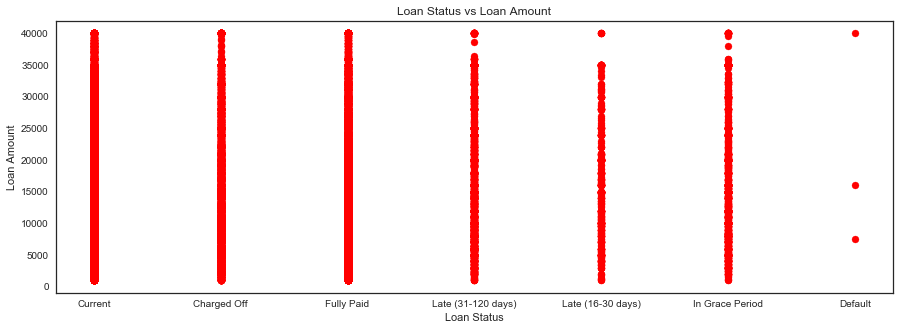

In [119]:
# Generate a scatter plot of Loan Amount and Loan Status using red circles
plt.figure(figsize=(15,5))
plt.scatter(clean_df['loan_status'],clean_df['loan_amnt'],label='data', color='red', marker='o')
plt.xlabel('Loan Status')
plt.ylabel('Loan Amount')
plt.title('Loan Status vs Loan Amount')
plt.show()


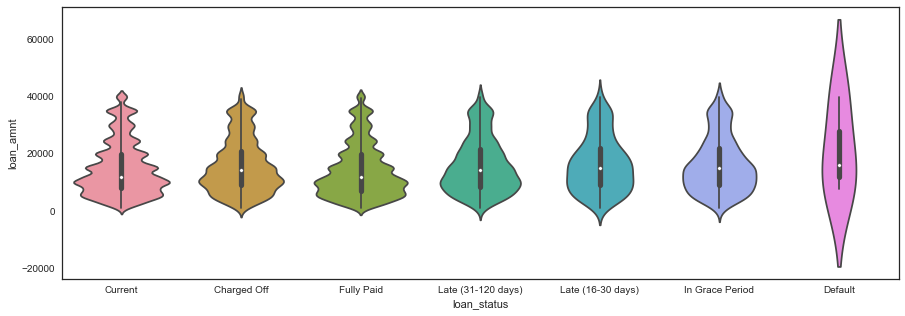

In [121]:
# Generate a violin plot Loan Amount vs Loan Status
plt.figure(figsize=(15,5))
plt.subplot(1,1,1)
sns.violinplot(x='loan_status', y='loan_amnt', data=clean_df)
plt.show()
